#### 0. 환경 설정

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

modu_ds_4_credit_card_fraud_detection_path = kagglehub.competition_download('modu-ds-4-credit-card-fraud-detection')

print('Data source import complete.')


100%|██████████| 67.0M/67.0M [00:00<00:00, 141MB/s]

Extracting files...


Data source import complete.


In [ ]:
!pip install -U scikit-learn==1.4.2 imbalanced-learn==0.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os

print(modu_ds_4_credit_card_fraud_detection_path)

/root/.cache/kagglehub/competitions/modu-ds-4-credit-card-fraud-detection


In [ ]:
import pandas as pd

train = pd.read_csv(os.path.join(modu_ds_4_credit_card_fraud_detection_path, 'train.csv'))
test = pd.read_csv(os.path.join(modu_ds_4_credit_card_fraud_detection_path, 'test.csv'))


#### 1. 데이터 이해 및 탐색

[문제 상황]
- Kaggle의 신용카드 데이터 셋을 활용해서 신용카드 사기 검출을 분류하여 고객이 구매하지 않은 상품에 대해 요금이 청구되지 않도록 신용카드 회사가 신용카드 사기 거래를 식별하는 미션을 수행하는 프로젝트

[데이터 설명]
- 모든 특징 변수는 수치형이며, 대부분은 PCA(주성분 분석)를 통해 변환된 값

| 컬럼 이름         | 설명                                                              |
| ------------- | --------------------------------------------------------------- |
| `V1` \~ `V28` | PCA 변환을 통해 얻어진 **주성분 특징들**<br>원래의 의미 있는 변수명은 제공되지 않음 (기밀 보호 목적) |
| `Time`        | 첫 거래 시점으로부터의 **경과 시간 (초)**                                      |
| `Amount`      | 해당 거래의 **금액**. 예시 기반 비용 민감 학습 등에 활용 가능                          |
| `Class`       | **목표 변수 (Target)**<br>사기 거래: `1`, 정상 거래: `0`                    |

[확인할 점]
- `V1`~`V28`은 변수 간 상관관계를 제거하기 위해 변환된 주성분이므로, 해석보다는 패턴 탐지 및 분류 모델링에 집중하자.

- `Amount`는 원본 스케일이 그대로 존재하며, 모델 입력 전 정규화 또는 로그 변환 등을 고려할 수 있음.

- `Class`는 극단적인 불균형 분포를 가지며 (0: 99.9%, 1: 0.1%), 따라서 정확도만으로 모델 성능을 평가하면 부정확할 수 있음.




##### 1-1. 데이터 살펴보기

In [ ]:
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
test.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,170883,120396.0,-2.410892,-1.264333,-0.787460,-0.212152,1.139859,-2.030200,0.533818,-0.194852,...,-0.558831,-0.076699,0.054816,-1.243901,0.147148,0.974330,1.309377,0.083660,-0.611166,124.98
1,170884,120396.0,-1.394526,0.284790,2.979226,0.362345,-1.344546,2.278858,-1.836101,-1.797895,...,-0.807798,1.945416,-0.539926,-0.446763,-0.521142,0.405680,-0.149237,0.458944,-0.071516,50.00
2,170885,120396.0,0.140378,0.989574,-0.506447,0.480553,1.407763,0.371637,0.811775,0.067702,...,0.120841,0.385872,1.302941,-0.177157,-0.192410,-0.724567,-0.433276,0.540947,0.323866,8.69
3,170886,120396.0,-1.303150,0.187865,0.944395,-1.277834,1.236744,-1.301696,1.402234,-0.558914,...,-0.251346,-0.274175,-0.656826,-0.164985,0.001284,-0.001842,-0.024050,-0.436872,0.051705,59.99
4,170887,120396.0,1.947883,-1.095332,-1.392121,-0.600598,-0.320840,0.048953,-0.443486,-0.081011,...,-0.293448,-0.250594,-0.385151,0.099030,0.221922,-0.212846,0.586637,-0.071616,-0.045475,119.97


In [ ]:
# 170882 를 기점으로 그 뒤 시점으로 자름

train["id"].max(), test["id"].min()

(170882, 170883)

In [ ]:
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 21  V20     17

In [ ]:
train["Class"].value_counts(normalize=True)*100

,proportion
Class,
0,99.78933
1,0.21067


##### 1-2. 전체 거래의 Time과 Amount

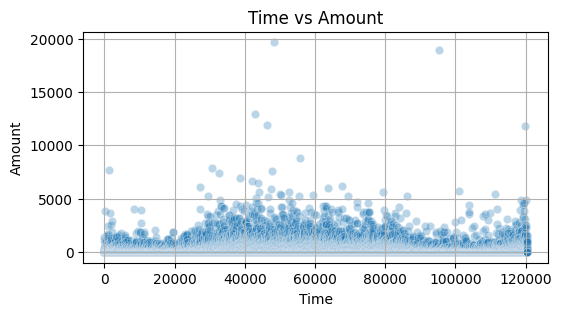

In [ ]:
plt.figure(figsize=(6, 3))
sns.scatterplot(data=train, x='Time', y='Amount', alpha=0.3)
plt.title('Time vs Amount')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

[결과 해석]
- 대부분의 거래 금액은 1000 이하의 소액 거래에 집중되어 있음
- 거래는 시간에 상관 없이 전반적으로 고르게 분포되어 있음
  - 40,000 ~ 80,000 초 구간에 거래량이 약간 많아 보이는 패턴 존재
- 일부 거래는 20,000 이상의 고액 거래도 발생하지만 빈도는 매우 낮음

##### 1-3. 사기 거래 (Class==1)

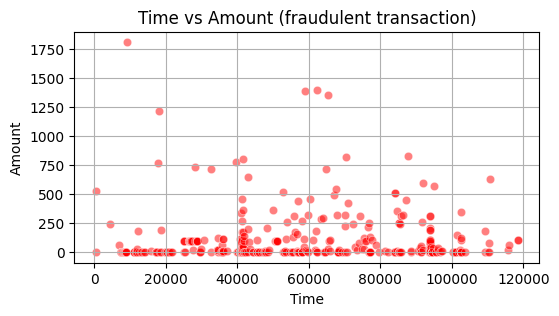

In [ ]:
plt.figure(figsize=(6, 3))
sns.scatterplot(data=train[train['Class'] == 1], x='Time', y='Amount', color='red', alpha=0.5)
plt.title('Time vs Amount (fraudulent transaction)')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

[결과 해석]
- 전체적으로 거래 금액이 작음, 대부분이 500 이하의 거래
  - 몇몇 고액 거래(1,000~1,750)가 보이긴 하지만, 극히 드문 케이스
- 시간에 따라 고르게 발생하지만, 30,000 ~ 60,000초 사이에 상대적으로 더 많은 사기 거래가 존재
- 0초 부근, 100,000초 이상 구간에서도 간헐적으로 사기 발생


##### 1-4. 정리

- 사기 거래는 주로 소액 거래에서 발생
- 사기 거래는 시간 전체에 걸쳐 발생하지만, 일정 시간대(3만~6만 초)에서 상대적으로 빈번하게 나타나는 경향이 보임
- 반면 일반 거래는 금액도 다양하고, 시간대도 더 고르게 분포함.


##### 1-5. 함수 정의

In [ ]:
def get_preprocessed_df(df=None, train=True):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy["Amount"])
    df_copy.insert(0, "Amount_Scaled", amount_n)
    df_copy.drop(["Time", "Amount"], axis=1, inplace=True)

    outlier_index = get_outlier(df=df_copy, column="V14", weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)

    return df_copy

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수

def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)

    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                        test_size=0.3, random_state=0, stratify=y_target)

    return X_train, X_test, y_train, y_test

In [ ]:
# 평가 함수

def get_clf_eval(y_test, pred, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    roc_auc = roc_auc_score(y_test, pred_proba)


    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision: .4f}, 재현율: {recall: .4f}, f1스코어: {f1:.4f}, roc-auc: {roc_auc:.4f}")

In [ ]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

---

### 2. 데이터 전처리

#### 2-1. 결측치 처리

In [ ]:
train.isnull().sum()

,0
id,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0


- 결측치는 보이지 않음.
- 그대로 진행하자.

#### 2-2. 이상치 처리

train 데이터의 전체적인 분포와 특징을 확인하자.

In [ ]:
train.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,...,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,85441.000000,61091.567090,-0.169838,0.040771,0.493037,0.117429,-0.176102,0.058235,-0.080669,0.032227,...,-0.028287,-0.083744,-0.022450,0.009008,0.092269,0.012603,0.002093,0.002445,87.336704,0.002107
std,49329.817362,27828.109419,1.850529,1.610874,1.383241,1.371910,1.338609,1.295123,1.208518,1.227630,...,0.743713,0.667318,0.584508,0.598760,0.465505,0.490660,0.391951,0.307315,245.954429,0.045851
min,0.000000,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-43.557242,-73.216718,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,42720.500000,41216.500000,-0.986667,-0.539174,-0.064747,-0.743475,-0.828769,-0.691129,-0.586314,-0.162638,...,-0.230722,-0.546777,-0.170294,-0.332459,-0.195933,-0.330346,-0.065125,-0.027054,5.480000,0.000000
50%,85441.000000,60776.000000,-0.183560,0.109679,0.623352,0.124307,-0.226228,-0.202634,-0.031932,0.056664,...,-0.054462,-0.066786,-0.036211,0.059474,0.135662,-0.058966,0.008693,0.021152,21.890000,0.000000
75%,128161.500000,78622.000000,1.184446,0.804221,1.297352,0.937632,0.374445,0.449200,0.462616,0.350995,...,0.128337,0.363165,0.098707,0.415860,0.399458,0.272938,0.089727,0.078302,76.720000,0.000000
max,170882.000000,120396.000000,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


In [ ]:
print(train['Amount'].describe())

count    170883.000000
mean         87.336704
std         245.954429
min           0.000000
25%           5.480000
50%          21.890000
75%          76.720000
max       19656.530000
Name: Amount, dtype: float64


문제점 1.
mean(87)에 비해 max(19656)이 상대적으로 크다.


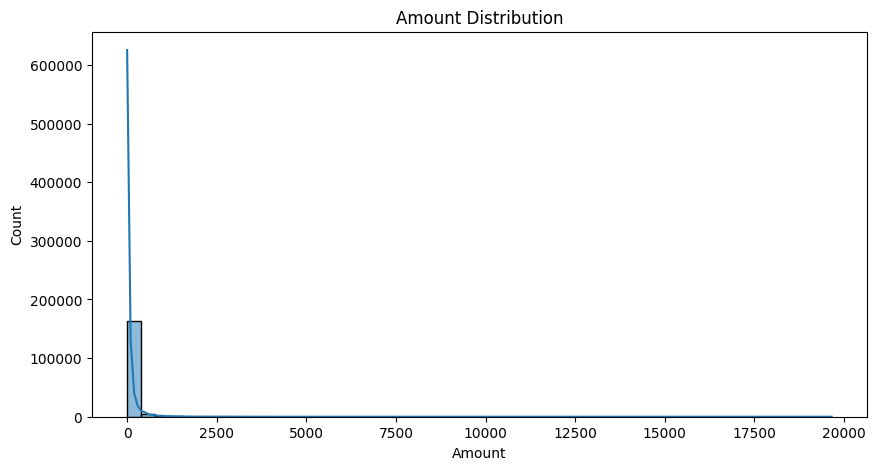

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(train['Amount'], bins=50, kde=True)
plt.title('Amount Distribution')
plt.show()

-> 로그 변환을 해보자.

log1p()를 이용해 간단히 변환이 가능하다.

2. corr()을 이용해 각 피처별로 상관도를 구하고, 사본의 heatmap을 통해 시각화해보자.

<Axes: >

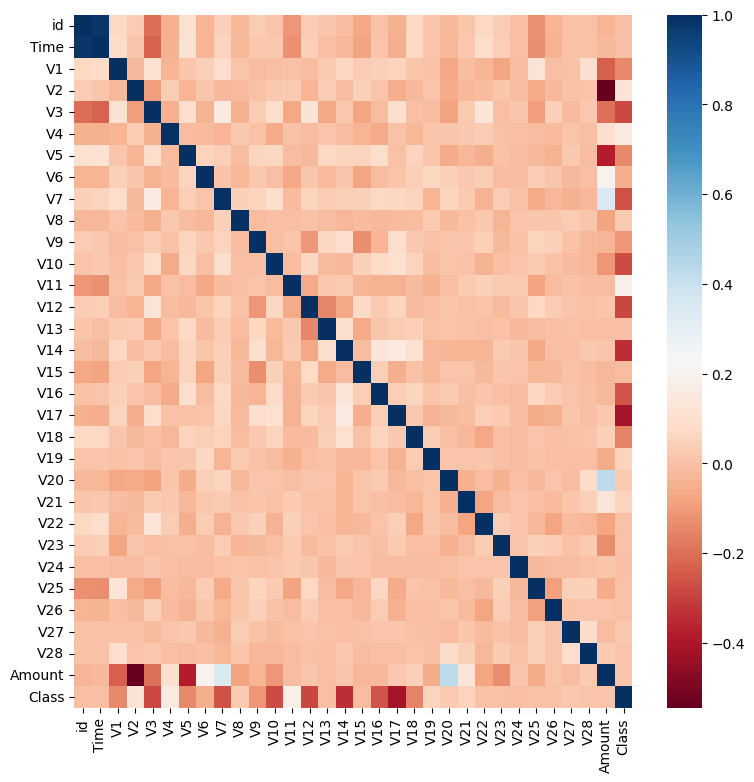

In [ ]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = train.corr()
sns.heatmap(corr, cmap='RdBu')

문제점 2.

- 양의 상관관계가 높음 : 파란색
- 음의 상관관계가 높음 : 빨간색

[결과]
결정 레이블인 `Class` 피처와 음의 상관관계가 높은 피처는 `V14`, `V17`

-> IQR을 이용해 이상치를 검출하는 함수를 생성한다.

In [ ]:
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df["Class"]==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

로그 변환 + IQR 을 통해 전처리를 하는 최종 함수를 만든다.

In [ ]:
# 최종 전처리
def get_preprocessed_df(df=None, train=True):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy["Amount"])
    df_copy.insert(0, "Amount_Scaled", amount_n) # 로그 변환을 한 새로운 변수를 만든다.
    df_copy.drop(["Time", "Amount"], axis=1, inplace=True) # 불필요한 변수 제거

    outlier_index = get_outlier(df=df_copy, column="V14", weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)

    return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(train)

In [ ]:
print("학습 데이터 레이블 값 비율")
print(y_train.value_counts()/y_train.shape[0] * 100)
print()
print("테스트 데이터 레이블 값 비율")
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.790998
1     0.209002
Name: count, dtype: float64

테스트 데이터 레이블 값 비율
Class
0    99.791277
1     0.208723
Name: count, dtype: float64


**SMOTE**
- 소수 클래스의 데이터를 인공적으로 생성하여 클래스 불균형을 완화하는 오버샘플링 기법

[사용 상황]
- 이진 분류 문제에서 클래스 비율이 매우 불균형할 때
(예: 정상 약 99.8%, 사기 0.17%)

[특징]
- `SMOTE`를 적용하면 재현율은 높아지나, 정밀도는 낮아진다는 것이 일반적
  - 때문에 정밀도 지표보다는 재현율 지표를 높이는 것이 머신러닝 모델의 주요한 목표인 경우, `SMOTE`를 적용하면 좋음
    - 필자는 재현율, ROC-AUC에 더 초점을 두고 있었기 때문에 `SMOTE`를 사용함.

[주의할 점]
- 반드시 **학습 데이터 세트**만 오버 샘플링을 해야 함.

In [ ]:
smote = SMOTE(random_state=0)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [ ]:
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (119616, 30) (119616,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (238732, 30) (238732,)
SMOTE 적용 후 레이블 값 분포: 
 Class
0    119366
1    119366
Name: count, dtype: int64


---

#### 3. 모델 선택 & 비교 & 평가

| 모델               | 특징 요약                                              | 장점                                  | 단점                                 |
|--------------------|--------------------------------------------------------|----------------------------------------|--------------------------------------|
| LogisticRegression | 선형 모델                                              | 빠르고 해석 용이                       | 비선형 문제에 약함, 재현율 낮을 수 있음 |
| LGBMClassifier     | 트리 기반 Gradient Boosting (LightGBM)                 | 빠르고 정확도·정밀도에 강함            | 하이퍼파라미터 튜닝에 민감             |
| XGBClassifier      | 트리 기반 Gradient Boosting (XGBoost)                  | 정교한 제어, 재현율/과적합에 강함      | 학습 속도가 느릴 수 있음               |


본 교재에 있는 두 개의 모델 외에 널리 쓰이는 XGBoost를 같이 사용하게 됐다.

세 모델에 대한 학습을 진행해보자.
- 일반 데이터셋과, STONE 기법을 적용한 데이터셋을 사용하였다.

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_clf = XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=6, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')
lr_clf = LogisticRegression(max_iter=1000)
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

##### 3-1. LogisticRegression

In [ ]:
get_model_train_eval(model = lr_clf, ftr_train=X_train,
                     ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[51145    12]
 [   42    65]]
정확도: 0.9989, 정밀도:  0.8442, 재현율:  0.6075, f1스코어: 0.7065, roc-auc: 0.9489


In [ ]:
get_model_train_eval(model = lr_clf, ftr_train=X_train_over,
                     ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[50559   598]
 [   13    94]]
정확도: 0.9881, 정밀도:  0.1358, 재현율:  0.8785, f1스코어: 0.2353, roc-auc: 0.9698


##### 3-2. LGBMClassifier

In [ ]:
get_model_train_eval(model = lgbm_clf, ftr_train=X_train,
                     ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

In [ ]:
get_model_train_eval(model = lgbm_clf, ftr_train=X_train_over,
                     ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

##### 3-3. XGBClassifier

In [ ]:
get_model_train_eval(model = xgb_clf, ftr_train=X_train,
                     ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[51150     7]
 [   19    88]]
정확도: 0.9995, 정밀도:  0.9263, 재현율:  0.8224, f1스코어: 0.8713, roc-auc: 0.9758


In [ ]:
get_model_train_eval(model = xgb_clf, ftr_train=X_train_over,
                     ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[51142    15]
 [   15    92]]
정확도: 0.9994, 정밀도:  0.8598, 재현율:  0.8598, f1스코어: 0.8598, roc-auc: 0.9836


##### 3-4. 결과

|모델|정확도|정밀도|재현율|f1스코어|ROC-AUC|
|------|---|---|---|---|---|
|LogisticRegression|0.9989|0.8442|0.6075|0.7065|0.9489|
|LogisticRegression(STOME)|0.9881|0.1358|0.8785|0.2353|0.9698|
|LGBMClassifier|0.9996|0.9570|0.8318|0.8900|0.9769|
|LGBMClassifier(STOME)|0.9995|0.8911|0.8411|0.8654|0.9793|
|XGBClassifier|0.9995|0.9263|0.8224|0.8713|0.9758|
|XGBClassifier(STOME)|0.9994|0.8598|0.8958|0.8598|0.9836|




다양한 모델(Logistic Regression, LGBMClassifier, XGBClassifier)을 비교한 결과, 전반적으로 SMOTE를 적용한 데이터가 재현율(Recall)과 ROC-AUC 성능을 개선하는 데 효과적이었음.

특히, XGBClassifier + SMOTE 적용 모델이 가장 높은 ROC-AUC (0.9836)를 기록하였고, 재현율 0.8958, F1-score 0.8598로 전반적인 성능 균형도 뛰어났음.

-> 최종 모델은 SMOTE를 적용한 학습 데이터로 훈련된 XGBClassifier로 선정

##### 3-5. 앙상블

- **앙상블**: 여러 개의 서로 다른 모델의 예측 결과를 결합하여, 단일 모델보다 더 나은 예측 성능과 안정성을 얻는 방법

- **소프트 보팅(Soft Voting, 확률 평균)**을 이용해 보는 방법 사용
 - 세 모델 각각의 `predict_proba()` 결과를 평균하여 최종 확률을 구한 후, 0.5 이상이면 1, 아니면 0으로 예측하는 방법


Logistic Regression, LGBMClassifier, XGBClassifier의 세 가지 개별 모델을 기반으로 Soft Voting 앙상블 모델을 구성하고 성능을 비교해보자.

In [ ]:
from sklearn.ensemble import VotingClassifier

xgb_clf = XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=6, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')
lr_clf = LogisticRegression(max_iter=1000)
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier( estimators=[('LR',lr_clf),('LGBM',lgbm_clf),('XGB',xgb_clf)] , voting='soft' )

vo_clf.fit(X_train , y_train)
pred = vo_clf.predict(X_test)
proba = vo_clf.predict_proba(X_test)[:, 1]
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))
print('Voting 분류기 ROC-AUC: {0:.4f}'.format(roc_auc_score(y_test , proba)))
print('Voting 분류기 F1-score: {0:.4f}'.format(f1_score(y_test , pred)))
print('Voting 분류기 Recall: {0:.4f}'.format(recall_score(y_test , pred)))

# 개별 모델의 학습/예측/평가.
classifiers = [lr_clf, lgbm_clf, xgb_clf]
for classifier in classifiers:
    classifier.fit(X_train , y_train)
    pred = classifier.predict(X_test)
    proba = classifier.predict_proba(X_test)[:, 1]
    class_name= classifier.__class__.__name__
    print(f"{class_name} 정확도: {accuracy_score(y_test, pred):.4f}")
    print(f"{class_name} AUC: {roc_auc_score(y_test, proba):.4f}")
    print(f"{class_name} F1-score: {f1_score(y_test, pred):.4f}")
    print(f"{class_name} Recall: {recall_score(y_test, pred):.4f}")
    print("-" * 40)

| 모델                   | 정확도        | AUC    | F1-score | Recall |
| -------------------- | ---------- | ------ | -------- | ------ |
| LogisticRegression   | 0.9989     | 0.9489 | 0.7065   | 0.6075 |
| LGBMClassifier       | 0.9996     | 0.9769 | 0.8900   | 0.8318 |
| XGBClassifier        | 0.9995     | 0.9758 | 0.8713   | 0.8224 |
| **VotingClassifier** | **0.9995** | **0.9553** | **0.8800**  | **0.8244**  |


캐글 문제는 신용카드 사기 거래 탐지로, 클래스 불균형이 매우 심한 이진 분류 문제이다.
- 이처럼 불균형이 심한 경우, 모든 샘플링을 0으로만 예측해도 정확도는 99.9%에 달함
- 정확도만 보면 모든 모델이 뛰어난 것 처럼 보이지만, 실질적으로 중요한 건

  - `Recall(재현율)` : 실제 사기 거래 중, 얼마나 잘 맞췄는가 (**중요**)
  - `F1-score`
  - `ROC-AUC` : 전체 예측 확률 분별력 (모델의 구분 성능!)

[결과 해석]

VotingClassifier는 개별 모델의 예측 확률을 평균(Soft Voting) 하여 예측을 수행함.

`Recall` 0.8244, `F1-score` 0.8800 으로 LGBM, XGB와 유사한 수준의 높은 성능을 기록하였고, 세 모델의 장점을 적절히 결합하면서 안정적인 예측 결과를 생성함.

-> 특히 사기 거래를 놓치지 않는 것(Recall) 과 전체적인 균형(F1-score) 이 중요한 본 문제에서
VotingClassifier는 높은 정밀성과 재현율의 균형을 유지하며, 안정적 성능을 제공하는 모델로 판단됨.

-> 앙상블 방식도 충분히 고려해볼 수 있는 전략 중 하나로 판단됨.

##### 3-6. 하이퍼파라미터 튜닝

`HyperOpt`를 이용하여 XGBoost 하이퍼 파라미터를 최적화해보자.

In [ ]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [ ]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|██████████| 20/20 [01:42<00:00,  5.11s/trial, best loss: -0.9995401952915998]
best: {'colsample_bytree': np.float64(0.684441779397407), 'learning_rate': np.float64(0.1475201153968472), 'max_depth': np.float64(9.0), 'min_child_weight': np.float64(2.0)}


In [ ]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.68444, learning_rate:0.14752, max_depth:9, min_child_weight:2


최적 하이퍼파라미터 조합
```
xgb_clf = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.14752,
    max_depth=9,
    min_child_weight=2,
    colsample_bytree=0.68444,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss',
)
```

##### 3-7. test 학습

In [ ]:
submission = pd.read_csv(os.path.join(modu_ds_4_credit_card_fraud_detection_path, 'sample_submission.csv'))


In [ ]:
test["Amount_Scaled"] = np.log1p(test["Amount"])

In [ ]:
test.drop(["Time", "Amount"], axis=1, inplace=True)

train과 test의 컬럼 순서가 달라 오류가 나서 (XGBoost는 내부적으로 컬럼 순서와 컬럼 이름을 엄격히 비교) 같은 순서로 맞춰주었다.

In [ ]:
# 1. test에서 Amount_Scaled 컬럼 꺼내기
amount_scaled_col = test['Amount_Scaled']

# 2. 나머지 컬럼 (Amount_Scaled 제외)
test_others = test.drop(columns=['Amount_Scaled'])

# 3. 두 번째 열 자리에 Amount_Scaled 끼워넣기
#    첫 번째는 'id', 두 번째는 'Amount_Scaled', 그 뒤 나머지
cols = test_others.columns.tolist()
cols.insert(0, 'Amount_Scaled')

# 4. 새로운 test DataFrame 만들기
test_fixed = test_others.copy()
test_fixed['Amount_Scaled'] = amount_scaled_col
test_fixed = test_fixed[cols]

In [ ]:
test = test_fixed

 SMOTE를 적용한 학습 데이터로 훈련된 XGBClassifier를 final_model로 선정하였다.

 - 하이퍼파라미터 튜닝을 한 값으로 진행했으나... 왜인지 더 score가 낮게 나오길래 기본 값으로 진행하였다.

In [ ]:
final_model = xgb_clf.fit(X_train_over, y_train_over)
xgb_pred = final_model.predict(test)
xgb_pred_proba = final_model.predict_proba(test)[:, 1]
test["Class"] = xgb_pred

In [ ]:
test.Class.value_counts()

,count
Class,
0,113809
1,114


In [ ]:
del submission["Class"]

In [ ]:
test["Class"] = xgb_pred_proba

In [ ]:
submission = submission.merge(test[["id", "Class"]], on="id")

In [ ]:
submission.to_csv("./submission.csv", index=False)

---